# metabolic HMM - test states
we are attempting to describe metabolic brain states with hidden Markov models.  To prove that this is feasible we are creating a toy model with two brain regions that are coupled.  We then define two states that correspond to different coupling coefficient.  To test the model, we will create a dataset from the model and then we will feed it into the analysis to see whether we can recreate the parameters from the data.

In [19]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import langevin
import theano.tensor as tt
from scipy import optimize

In [20]:
# transition matrix for states A and B
P=np.array([[0.99,0.01],[0.02,0.98]])
P1 = P[0,0]
P2 = P[1,0]
PA = P2/(P2+1-P1)
PB = 1 - PA
print(P1,P2,PA,PB)

# create a sample
firstpoint = np.random.choice(2, 1, p=[PA,PB])
sample = [firstpoint[0]]
for i in range(1,10000):
    sample = np.concatenate((sample,np.random.choice(2,1,p=P[sample[-1]])))

0.99 0.02 0.666666666667 0.333333333333


(-0.1, 1.1)

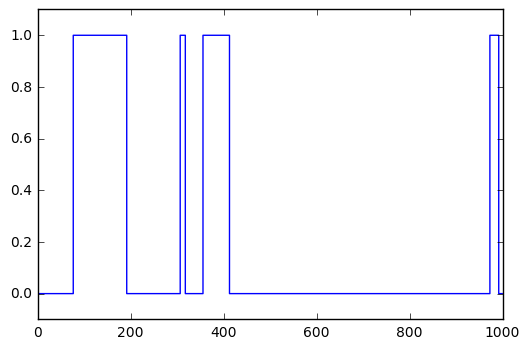

In [21]:
# plot the state variable
plt.plot(sample[:1000], drawstyle='steps-mid')
plt.ylim((-0.1,1.1))

In [22]:
print(not 1)

False


In [23]:
# to simulate the data we need to calculate the time intervals for each state
first = sample[0]
first_index = 0
intervals=[]
while first_index<len(sample):
    if first==0:
        first=1
    else:
        first=0
    try:
        change = next(i+first_index for i,state in enumerate(sample[first_index:]) if state==first)
    except:
        change = len(sample)
    intervals.append([first_index,change])
    first_index = change


(array([ 0.00956858,  0.00471495,  0.00152543,  0.00083205,  0.00041603,
         0.00041603,  0.00013868,  0.00013868,  0.        ,  0.00013868]),
 array([   1. ,   56.9,  112.8,  168.7,  224.6,  280.5,  336.4,  392.3,
         448.2,  504.1,  560. ]),
 <a list of 10 Patch objects>)

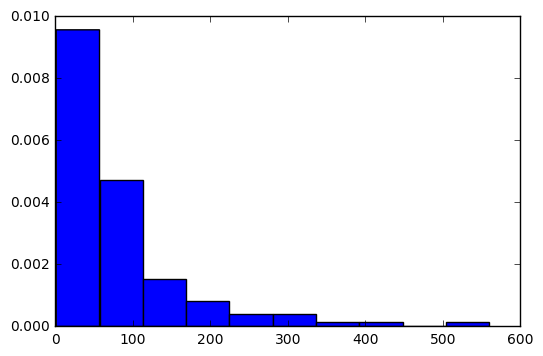

In [24]:
#print(intervals)
lengths=[interval[1]-interval[0] for interval in intervals]
plt.hist(lengths,normed=True)

In [25]:
#now we need to calculate the signal from the two brain regions
def time_series(A,D,delta_t,N):
    """ returns a time series that is the solution of a Langevin equation describing a Brownian particle in a harmonic potential
    :param A: mean square amplitude - oscillator strength
    :param D: Diffusion coefficient
    :param delta_t: time step
    :param N: number of samples that are returned
    :return:
    """
    # using Smolukowski solution for simulation

    #first point
    x=[np.random.normal(0,np.sqrt(A[0]))]
    stddev = np.sqrt(A * (1.0 - np.exp(-2.0 * D / A * delta_t)))

    for i in range(1,N):
        x.append(np.random.normal(x[-1]*np.exp(-D[i]/A[i]*delta_t),stddev[i]))

    return np.array(x)


In [26]:
# before we get to our more complicated model we create a one node model with different amplitudes
AA=np.array([0.1,1.0])
DD=np.array([1.0,1.0])
A=AA[sample]
D=DD[sample]
delta_t=0.2
simple_sample=time_series(A,D,delta_t,len(sample))

10000


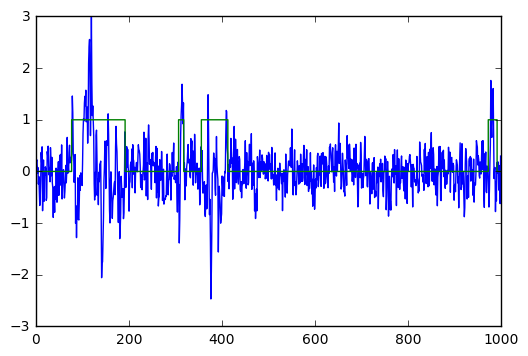

In [27]:
print(simple_sample.size)
plt.plot(simple_sample[:1000])
plt.plot(sample[:1000], drawstyle='steps-mid')


In [28]:
class HMMStates(pm.Categorical):
    """
    Hidden Markov Model States
    Parameters
    ----------
    P1 : tensor
        probability to remain in state 1
    P2 : tensor
        probability to move from state 2 to state 1
    
    """

    def __init__(self, PA=None, P1=None, P2=None,
                 *args, **kwargs):
        super(pm.Categorical, self).__init__(*args, **kwargs)
        self.PA = PA
        self.P1 = P1
        self.P2 = P2
        self.k = 2 # two state model
        self.mean = 0.
        self.mode = tt.cast(0,dtype='int64')

    def logp(self, x):
        PA = self.PA
        P1 = self.P1
        P2 = self.P2
        
        # now we need to create an array with probabilities
        # so that for x=A: PA=P1, PB=(1-P1)
        # and for x=B: PA=P2, PB=(1-P2)
        # for more than two states we may use tt.choose()
#        length = x.shape[0]
        PT = tt.stack((P1,P2))
        
        P = PT[x[:-1]]
        
        x_i = x[1:]
        
        ou_like = pm.Categorical.dist(P, shape=(N_chain-1,2)).logp(x_i)
        return pm.Categorical.dist(PA).logp(x[0]) + tt.sum(ou_like)

In [29]:
class HMMUhlenbeckOrnsteinEmissions(pm.Continuous):
    """
    Hidden Markov Model Gaussian Emissions
    Parameters
    ----------
    A1,A2 : tensor
        prior for amplitudes of the two states
        shape = (2,N_states)
        
    D1,D2 : tensor
        prior for diffusion coefficient of the two states
        shape = (2,N_states)
    
    states : tensor
         hidden states (integer 0..(N_states-1))
         shape = (N_states)
    
    """

    def __init__(self, A1=None, A2=None, D1=None, D2=None, delta_t=0.01, states=None,
                 *args, **kwargs):
        super(HMMUhlenbeckOrnsteinEmissions, self).__init__(*args, **kwargs)
        self.A1 = A1
        self.D1 = D1
        self.A2 = A2
        self.D2 = D2
        self.states = states
        self.mean = 0.

    def logp(self, x):
        A1 = self.A1
        D1 = self.D1
        A2 = self.A2
        D2 = self.D2
        states = self.states
        
        # create an array of amplitudes that correspond to the states
        AT = tt.stack((A1,A2))
        AS = AT[states]
        
        # create an array of diffusion coefficients that correspond to the states
        DT = tt.stack((D1,D2))
        DS = DT[states]
        
        B = tt.exp(-delta_t * DS / AS)
        
        x_im1 = x[:-1]
        x_i = x[1:]

        ou_like = pm.Normal.dist(mu=x_im1*B[1:], tau=1.0/AS[1:]/(1-B[1:]**2)).logp(x_i)
        return pm.Normal.dist(mu=0.0,tau=1.0/AS[0]).logp(x[0]) + tt.sum(ou_like)


In [30]:
# Two state model for simplicity.
N_states = 2
N_chain = len(sample)
print(N_chain)

# Transition probability stochastic
theta1=np.array([3.0,1.0])
theta2=np.array([1.0,3.0])
aA1=0.00333
bA1=0.0333
aA2=0.333
bA2=0.333
aD=2.333
bD=1.333
    
with pm.Model() as model:
    # 2 state model
    # P1 is probablility to stay in state 1
    # P2 is probability to move from state 2 to state 1
    P1 = pm.Dirichlet('P1', a=theta1)
    P2 = pm.Dirichlet('P2', a=theta2)
    
    PA = pm.Deterministic('PA',P2/(P2+1-P1))
    
    states = HMMStates('states',PA,P1,P2, observed = sample)
    
    start = pm.find_MAP(fmin=optimize.fmin_powell)
#    step1 = pm.Metropolis(vars=[P1, P2, PA])
#    step2 = pm.BinaryGibbsMetropolis(vars=[states])
    trace = pm.sample(10000, start=start)

10000


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Optimization terminated successfully.
         Current function value: 683.725289
         Iterations: 2
         Function evaluations: 61


Average ELBO = -686.06: 100%|██████████| 200000/200000 [11:04<00:00, 301.02it/s]
Finished [100%]: Average ELBO = -686.07
100%|██████████| 10000/10000 [04:56<00:00, 33.78it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121ba2dd8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x127461c50>]], dtype=object)

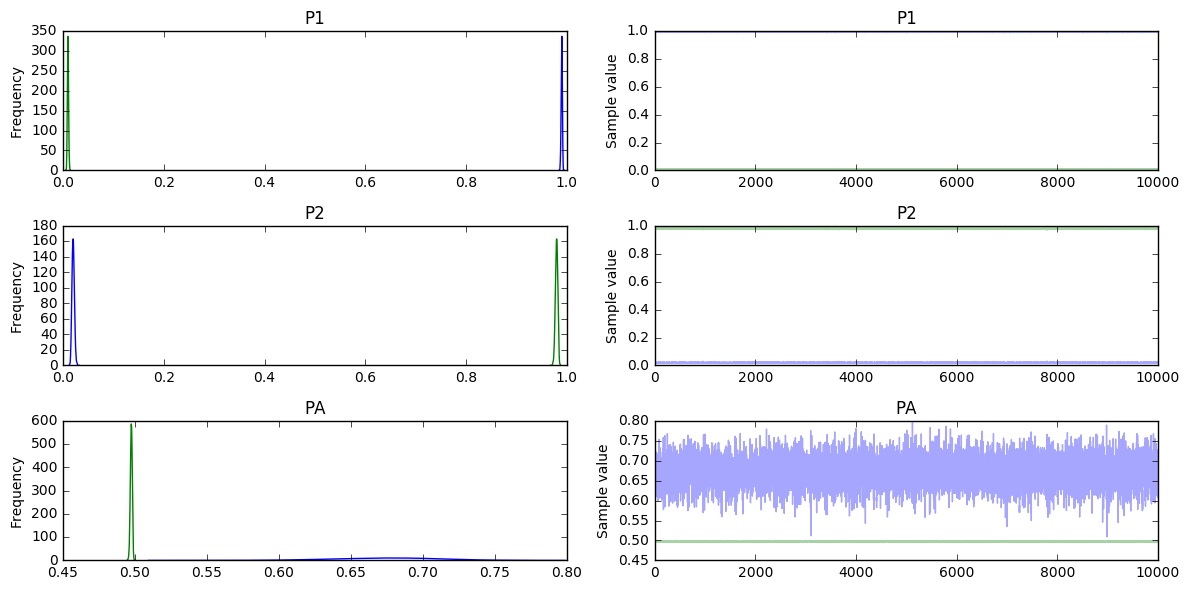

In [31]:
pm.traceplot(trace)

In [32]:
pm.summary(trace)


P1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.990            0.001            0.000            [0.988, 0.993]
  0.010            0.001            0.000            [0.007, 0.012]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.988          0.990          0.990          0.991          0.993
  0.007          0.009          0.010          0.010          0.012


P2:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.020            0.002            0.000            [0.015, 0.024]
  0.980            0.002            0.000            [0.976, 0.985]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|===========